## Decision Tree Classifier with scikit-learn

Dataset used: Heart Failure Prediction from Kaggle: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Import the data file that you can download from the kaggle link above and look at the data format.

In [2]:
heart_data = pd.read_csv('heart.csv')
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Now separate the features from the target variable (HeartDisease).

In [3]:
heart_data_x = heart_data.drop("HeartDisease", axis=1)
heart_data_y = heart_data['HeartDisease']

Replace all categorical data with "dummy" variables through one-hot-encoding through pandas.get_dummies()

Why? Scikit-learn decision trees can't deal with categorical data, it needs to be in numerical format. An easy way to achieve that is to create multiple columns, one for each possible value of the categorical data. 

Example: ST_Slope with the values Up, Down & Flat will be replaced by the columns "ST_Slope_Up", "ST_Slope_Flat" & "ST_Slope_Down". Then each row has a 1 or 0 depending on if this patient has this particular Slope as a characteristic. You can leave out one of those columns (by setting drop_first=True) to save redundant information, because if "ST_Slope_Up" and "ST_Slope_Flat" are both False, then the only remaining possibility is that the patient has a downwards slope. 

In [6]:
heart_data_x_encoded = pd.get_dummies(heart_data_x, drop_first=True)
heart_data_x_encoded.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,1,0,1,0,1,0,0,0,1


That's it for pre-processing.

Next we split the dataset into a training and testing part:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(heart_data_x_encoded, heart_data_y, test_size=0.3)

### Build the tree (basic)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtree = DecisionTreeClassifier(max_depth=2)
dtree.fit(X_train, y_train)
train_predictions = dtree.predict(X_train)
test_predictions = dtree.predict(X_test)
train_acc = accuracy_score(y_train, train_predictions)
test_acc = accuracy_score(y_test, test_predictions)
print('train acc', train_acc)
print('test acc', test_acc)

train acc 0.8364485981308412
test acc 0.8333333333333334


#### Hyperparameter tuning idea

Here is a basic script for optimizing a few of the possible hyperparameters by using a grid-search. For full documentation, read here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

- criterion can be either "gini" or "entropy"
- max_depth is an integer
- min_samples_leaf is the amount of patients each leaf of the tree has to hold

The latter two are both regularizers and limiting them is a way to avoid overfitting. They reduce the amount of functions the tree can represent. Of course, they also limit the accuracy you can achieve (keyword: Bias-Variance-Tradeoff).

In [13]:
best_acc = 0

for criterion in ['gini', 'entropy']:
    for max_depth in [2,3,4,5,6]:
        for min_samples_leaf in [5, 10, 20, 30]:
            dtree = DecisionTreeClassifier(max_depth=max_depth, criterion=criterion, min_samples_leaf=min_samples_leaf)
            dtree.fit(X_train, y_train)
            test_predictions = dtree.predict(X_test)
            test_acc = accuracy_score(y_test, test_predictions)
            if test_acc > best_acc:
                best_params = f"criterion: {criterion}, max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf}"
                best_acc = test_acc
                

In [14]:
print(best_params)
print(best_acc)

criterion: entropy, max_depth: 5, min_samples_leaf: 5
0.8731884057971014


### Visualizing the Tree

If the tree is not too detailed, it can be a good idea to look at it visually to examine the most important decision rules of the classifier. This can also be helpful for presenting your results to colleagues, managers & stakeholders.

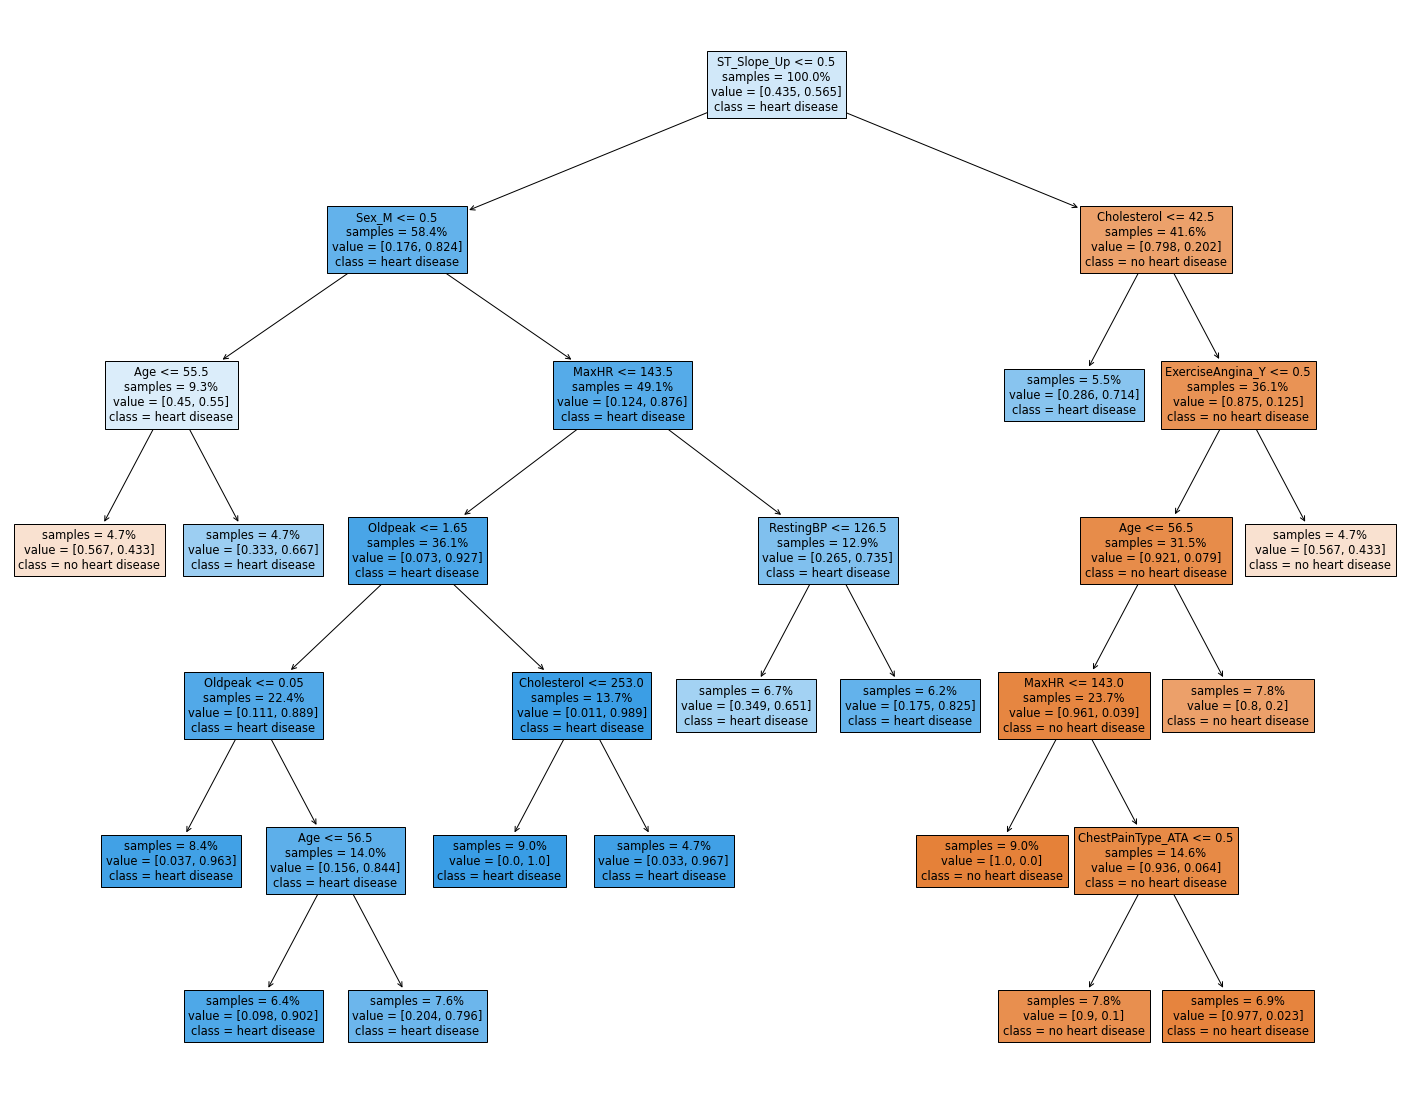

In [15]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=((25,20)))
plot_tree(dtree, 
            feature_names = heart_data_x_encoded.columns,
            class_names=['no heart disease', 'heart disease'],
            impurity=False,
            proportion=True,
            filled=True)
fig.savefig('heart_failure_decision_tree.png')